# Recoloring with cellular automatas

We are going to try to recolor an image based on another image using techniques from cellular automatas, a 2D Moore neighborhood will be used

The grayscaling algorithms used is the default one used by [the Pillow library (ITU-R 601-2 luma transform)](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.Image.convert), that works as follows for each pixel in RGB color space:
$$L = R * 299/1000 + G * 587/1000 + B * 114/1000$$

# Preamble

Imports and configuration

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from collections import defaultdict

plt.ioff()

## Google Colab Drive
If you want to run the cellular automata with files from drive run this block

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Enconding Helper

A function that helps us easily test different rule generation strategies

We define a generic encode function that receives as argument the reference image and a strategy, and it returns a decodification function. The strategy is also a function, it takes as arguments the neighborhoods of gray pixels and the original color array and returns a function that will be used as rules for decodification.



In [4]:
def encode(im,strategy):
  # Convert image to grayscale
  # The library uses the ITU-R 601-2 luma transform
  # L = R * 299/1000 + G * 587/1000 + B * 114/1000
  im_gray = im.convert('L')

  # Convert colored image to array (excluding the borders and the gamma color channel)
  ar_col = np.array(im)[1:-1,1:-1,0:3]

  # Grayscale image to array
  ar_gray = np.array(im_gray)

  # Create the 3 x 3 neighborhoods from the grayscale array
  neigh = sliding_window_view(ar_gray,(3,3))

  # apply the strategy to create the rules
  rules = strategy(neigh,ar_col)

  # decodification
  def decode(new_im):

    # Make sure image is grayscaled (Notice that the transform used preserves
    # values for image that have been already grayscaled)
    new_ar_gray = np.array(new_im.convert('L'))
    # We get the neighborhoods
    new_neigh = sliding_window_view(new_ar_gray, (3,3))
    # We define a vectorized functions that works over the (3,3) subarrays
    # and returns a (1,3) vector (for the color channels)
    dec = np.vectorize(rules, signature="(3,3)->(3)")

    # We decode the image
    res = dec(new_neigh)

    # And transform it back from array to image
    return Image.fromarray(res)

  return decode


In [5]:
# Little utility func
create_encoder = lambda e: lambda im: encode(im,e)

# Images

Files and functions to help testing different strategies

## Testing subroutine
This helps applying the encoding function to each image and then decoding each image again (after converting to grayscale) to see different results with varying sources

In [6]:
def compare_images(source_images, encode_function, strategy_name=None):
  #decoding_functions = list(map(encode_function,source_images))
  decoding_functions = [encode_function(im) for im in source_images]
  #decoded_images = list(map(lambda f: list(map(f,source_images)), decoding_functions))
  decoded_images = [[f(im.convert('L')) for im in source_images] for f in decoding_functions]

  n_imgs = len(source_images)
  #fig, axes = plt.subplots(n_imgs, n_imgs+1, figsize=(12,8))
  fig = plt.figure(layout='constrained',figsize=(12,8))
  subfigs = fig.subfigures(1,2, width_ratios=[1,n_imgs])

  subfigs[0].suptitle("Sources")
  source_ax = subfigs[0].subplots(n_imgs,1)
  subfigs[1].suptitle("Results")
  result_ax = subfigs[1].subplots(n_imgs, n_imgs)

  for i,(source_img, dec_images) in enumerate(zip(source_images, decoded_images)):
    source_ax[i].imshow(source_img)
    for j,dec_img in enumerate(dec_images):
      result_ax[i,j].imshow(dec_img)

  if strategy_name is not None:
    fig.suptitle(f'Recoloring using {strategy_name}', size='x-large', weight='black')

  return fig


## Files
Image files loading

In [7]:
# Set this variable accordingly, as the path prefix for the images
img_folder = r'/content/drive/MyDrive/UNIVERSIDAD/semestre 7/IA & minirobots/recolor CA/images/'

In [8]:
image_names = ["macarons.jpg","meow.png","meow2.jpg","foto_ricardo.jpeg"]
images = [Image.open(img_folder + n) for n in image_names]
images = [img.resize((img.size[0]//4,img.size[1]//4)) for img in images]

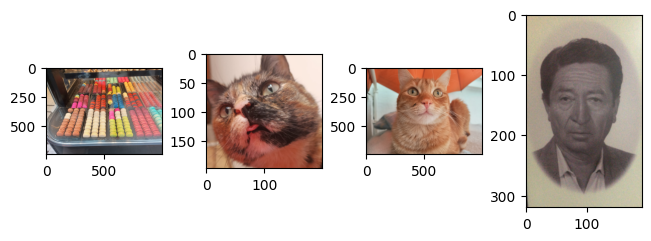

In [9]:
def show_images():
  n_imgs = len(images)
  fig, axes = plt.subplots(1,n_imgs,layout="constrained")
  for i,img in enumerate(images):
    axes[i].imshow(img)

  return fig

show_images()

# "Brute force"

The simplest algorithm, take the neighborhoods and codify them as literal rules for their corresponding colors. It is a dictionary of 9-tuples to colors. The default color when a rule is not found is black.
## Advantages (+)
- It is simple and pretty straightforward to implement
- Relatively fast

## Disadvantages (-)
- As the rules are defined by unique 9-tuples representing the neighborhoods, if some neighborhood was not present in the original image, there will not be a rule for it.

In [10]:
def bruteforce(neigh,ar_col,black_unknown=True):
  # Flatten arrays to simplify iteration
  neigh_flat = neigh.reshape((neigh.shape[0]*neigh.shape[1],3,3))
  ar_col_flat = ar_col.reshape((ar_col.shape[0]*ar_col.shape[1],3))
  # Dictionary of rules, it defaults to a black pixel if the rule is not found
  rules = defaultdict(lambda: np.array([0,0,0], dtype="uint8"))
  for k,v in zip(neigh_flat,ar_col_flat):
      rules[tuple(k.flatten())] = v

  if black_unknown:
    return lambda x: rules[tuple(x.flatten())]

  def dec(x):
    t = tuple(x.flatten())
    if t in rules:
      return rules[t]
    else:
      return np.ones((1,3),dtype="uint8") * x[1,1]
  return dec


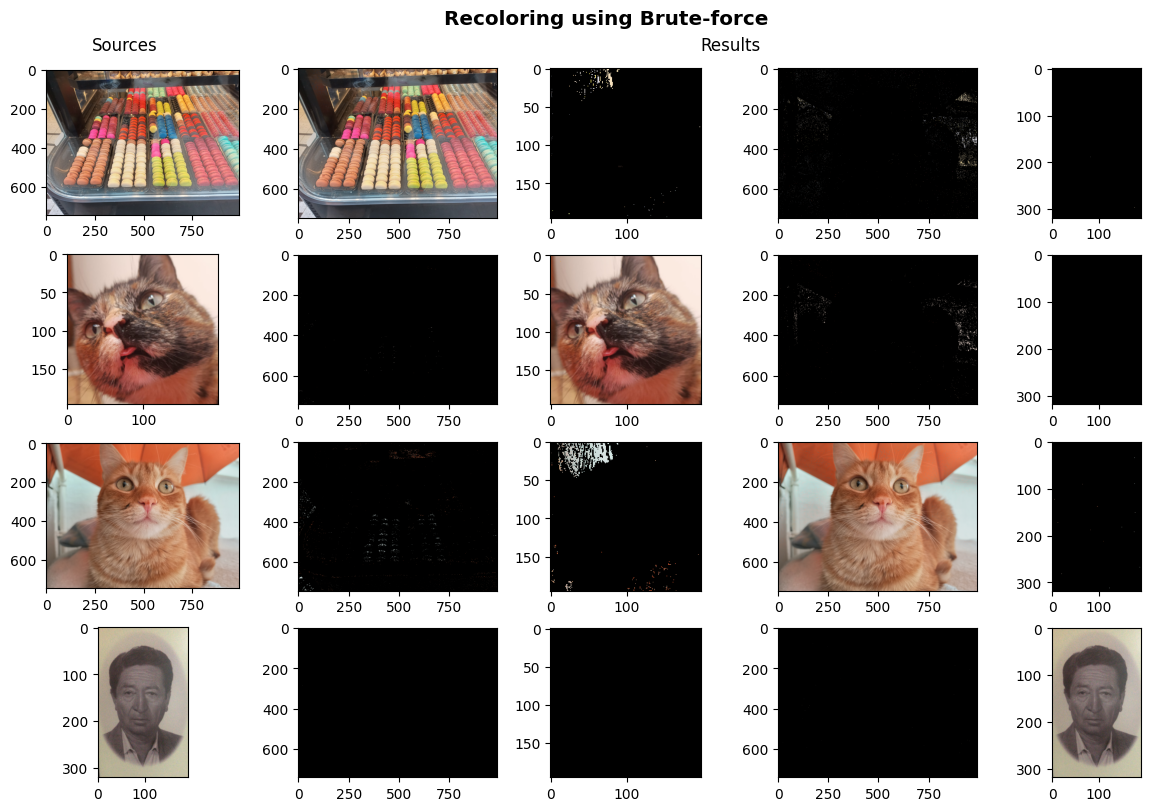

In [11]:
compare_images(images,create_encoder(bruteforce),"Brute-force")

# Closest vector

Interpreting the neighborhoods as 9 dimentional vectors, we make use of a k-d tree to store the original vectors and then query the tree with new image neighborhoods finding the closest one for color assigning

## Advantages
- There will always be a closest vector, that means no uncolored images
- The relations between colors are keep well enough so that the recolored images are still understandable

## Disadvantages
- Vector search algorithms are complex, although we used scipy implementation to simplify the codign process, recoloring is slow
- No new colors emerge, we are still limited to the original image colors

In [12]:
from scipy.spatial import KDTree

In [13]:
def vector_search(neigh,ar_col):
  vec_list = neigh.reshape((neigh.shape[0]*neigh.shape[1],9))
  col_list = ar_col.reshape((ar_col.shape[0]*ar_col.shape[1],3))
  tree = KDTree(vec_list,balanced_tree=True)

  def _query(x):
    v = x.reshape((1,9))
    _dist, idx = tree.query(v, workers=-1)
    return col_list[idx[0]]
  return _query

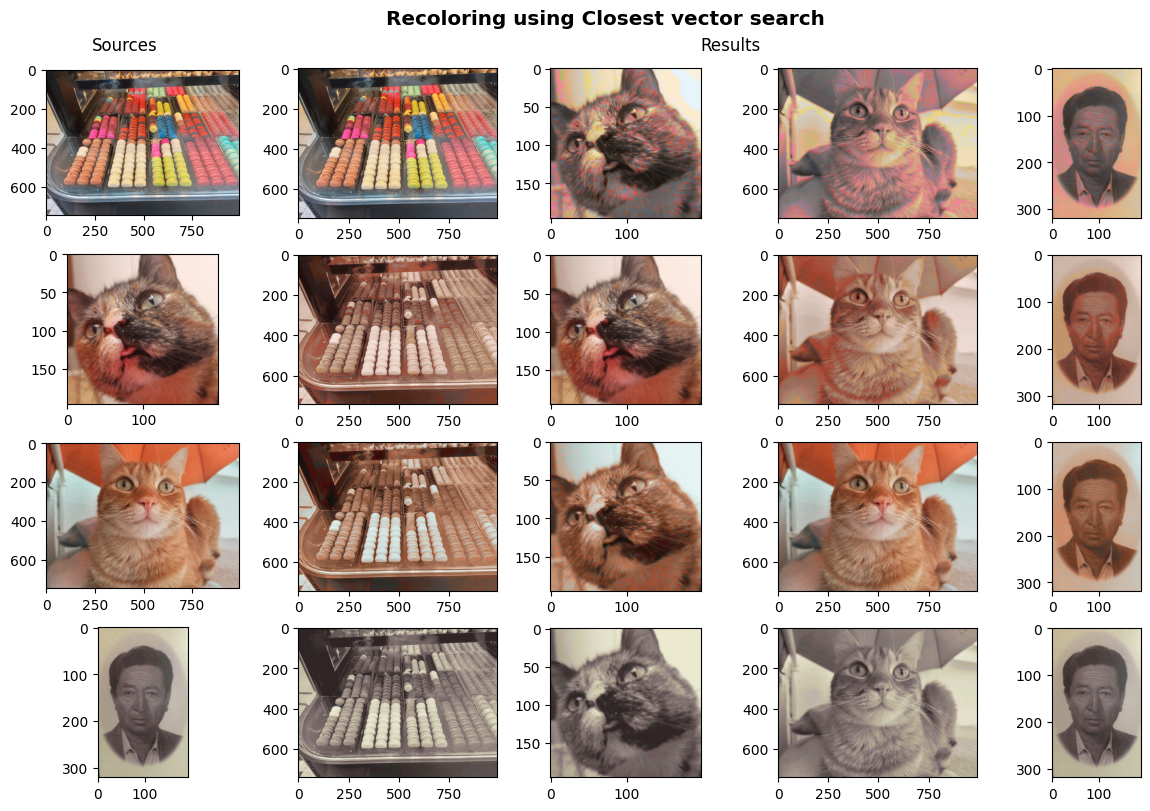

In [14]:
compare_images(images,create_encoder(vector_search), "Closest vector search")

# Miscellaneous code
For testing and experimentation purposes

## Color cube

In [ ]:
from numpy.core.numeric import moveaxis
rrr = moveaxis(np.mgrid[0:256,0:256,0:256],0,-1).astype('uint8')

In [ ]:
rrr.shape

(256, 256, 256, 3)

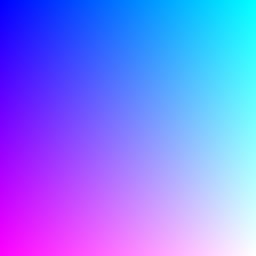

In [ ]:
Image.fromarray(rrr[:,:,255])